In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

import os 

In [3]:
from config import DATA_PATH, VIDEOS_PATH
import pandas as pd
from sklearn.model_selection import train_test_split
from config import SPLITS
from numpy.random import default_rng
import shutil
import pathlib

## 0. Data Preparation

In [4]:
# Load the labels data
labels = pd.read_csv('./data/labels.csv')
labels

,gloss_id,gloss,hand
0,1,Opaque,R
1,2,Red,R
2,3,Green,R
3,4,Yellow,R
4,5,Bright,R
...,...,...,...
59,60,Copy,B
60,61,Run,B
61,62,Realize,R
62,63,Give,B


In [5]:
list_of_videos = os.listdir(VIDEOS_PATH)
print(f"The number of videos in the dataset is: {len(list_of_videos)}")

The number of videos in the dataset is: 3200


In [6]:
# Create a metadata dictionary
metadata_dict = {
    "video_id": [],
    "gloss_id": [],
    "interpreter_id": [],
    "take_id": []
}

for video_id in list_of_videos:
    str_splits = video_id.split("_")
    gloss_id, interpreter_id, take_id = int(str_splits[0]), str_splits[1], str_splits[2].split(".")[0]
    metadata_dict["gloss_id"].append(gloss_id)
    metadata_dict["interpreter_id"].append(interpreter_id)
    metadata_dict["take_id"].append(take_id)
    metadata_dict["video_id"].append(video_id)

metadata_df = pd.DataFrame(metadata_dict)
metadata_df

,video_id,gloss_id,interpreter_id,take_id
0,019_006_005.mp4,19,006,005
1,039_004_001.mp4,39,004,001
2,011_009_003.mp4,11,009,003
3,037_005_004.mp4,37,005,004
4,011_006_002.mp4,11,006,002
...,...,...,...,...
3195,019_002_004.mp4,19,002,004
3196,051_002_001.mp4,51,002,001
3197,051_003_001.mp4,51,003,001
3198,024_010_005.mp4,24,010,005


In [7]:
# Join both dictionaries
full_metadata_df = metadata_df.merge(labels, on='gloss_id')
full_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand
0,019_006_005.mp4,19,006,005,Bitter,R
1,019_006_001.mp4,19,006,001,Bitter,R
2,019_003_004.mp4,19,003,004,Bitter,R
3,019_002_001.mp4,19,002,001,Bitter,R
4,019_004_004.mp4,19,004,004,Bitter,R
...,...,...,...,...,...,...
3195,013_006_003.mp4,13,006,003,Away,R
3196,013_002_003.mp4,13,002,003,Away,R
3197,013_007_001.mp4,13,007,001,Away,R
3198,013_001_005.mp4,13,001,005,Away,R


In [8]:
# Check that there are no nulls
full_metadata_df.isnull().any(), full_metadata_df.isna().any()

(video_id          False
 gloss_id          False
 interpreter_id    False
 take_id           False
 gloss             False
 hand              False
 dtype: bool,
 video_id          False
 gloss_id          False
 interpreter_id    False
 take_id           False
 gloss             False
 hand              False
 dtype: bool)

In [9]:
metadata_4_train, metadata_4_test = train_test_split(full_metadata_df, test_size=0.2, shuffle=True)
metadata_4_val, metadata_4_test = train_test_split(metadata_4_test, test_size=0.4, shuffle=True)

In [10]:
metadata_4_train["sp"] = 'train'
metadata_4_val["sp"] = 'val'
metadata_4_test["sp"] = 'test'
full_metadata_df = pd.concat([metadata_4_train, metadata_4_val, metadata_4_test])
full_metadata_df.reset_index()
full_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand,sp
1854,003_007_005.mp4,3,007,005,Green,R,train
2684,045_006_001.mp4,45,006,001,Barbecue,B,train
2002,052_001_001.mp4,52,001,001,Shut down,R,train
1065,006_003_002.mp4,6,003,002,Light-blue,R,train
2010,052_001_002.mp4,52,001,002,Shut down,R,train
...,...,...,...,...,...,...,...
1096,006_007_002.mp4,6,007,002,Light-blue,R,test
3140,042_004_005.mp4,42,004,005,Deaf,R,test
77,039_007_004.mp4,39,007,004,Name,R,test
192,037_002_003.mp4,37,002,003,Ship,R,test


In [11]:
# we take a subset of classes from the whole dataset
rng = default_rng()
subset_size = 10
subset_labels = rng.choice(len(labels), size=subset_size, replace=False)

subset_metadata_df = full_metadata_df[full_metadata_df['gloss_id'].isin(subset_labels)]
subset_metadata_df.reset_index()
subset_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand,sp
1423,056_007_002.mp4,56,007,002,Help,B,train
592,058_002_004.mp4,58,002,004,Bathe,B,train
2933,054_005_005.mp4,54,005,005,To land,B,train
2495,055_004_002.mp4,55,004,002,Catch,B,train
521,017_010_004.mp4,17,010,004,Call,R,train
...,...,...,...,...,...,...,...
2912,054_007_001.mp4,54,007,001,To land,B,test
1410,056_008_003.mp4,56,008,003,Help,B,test
506,017_004_004.mp4,17,004,004,Call,R,test
1130,051_007_004.mp4,51,007,004,Thanks,B,test


In [12]:
CREATE_SUBSET = False
erase_original = False
subset = f"subset_{subset_size}_lsa_64"

In [13]:
if CREATE_SUBSET:
    # iterate through rows of the dataset
    for index, row in subset_metadata_df.iterrows():
        source = os.path.join(VIDEOS_PATH, row['video_id'])
        destination = os.path.join(DATA_PATH, subset, row['sp'], row['gloss'])

        # create the dataset structure /data/videos/<train|test|val>/gloss
        if not os.path.exists(destination): 
            os.makedirs(destination)

        # and now, we copy from /data/videos to /data/subset_{subset_size}_lsa_64/<train|test|val>/gloss
        if os.path.exists(source):
            shutil.copy(source, destination)

        if erase_original:
            os.remove(source)

In [14]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

## 1. Data Augmentation

In [15]:
import random
import cv2
import numpy as np
import vidaug.augmentors as va 
from PIL import Image
from tqdm import tqdm
from augment_dataset import video_loader, data_transformer, from_PIL_to_opencv
MAX_AUG = 1
DATA_AUG = False
random.seed()

In [16]:
to_aument = random.randint(0, MAX_AUG)
subset_path = os.path.join(DATA_PATH, subset)

In [17]:
if DATA_AUG:
    for sp in SPLITS:
        for gloss in tqdm(os.listdir(os.path.join(subset_path, sp))):
            for video_name in os.listdir(os.path.join(subset_path, sp, gloss)):
                for i in range(to_aument):
                    video_path = os.path.join(subset_path, sp, gloss, video_name)
                    # get metadata from the video and encoding the output
                    cap = cv2.VideoCapture(video_path)
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    fourCC = cv2.VideoWriter_fourcc("m", "p", "4", "v")
                    # retrieve frames as PIL images
                    frames = video_loader(video_path)
                    # get frame width and height
                    frame_width, frame_height = frames[0].size

                    vid_name = video_name.split(".")[0]
                    aug_vid_name = f"{vid_name}_aug{i}.mp4"
                    aug_frames = data_transformer(frames, frame_height, frame_width, crop_factor=0.2)
                    new_frame_width, new_frame_height = aug_frames[0].size
                    cv2_frames = from_PIL_to_opencv(aug_frames)  
                    path_out = os.path.join(subset_path, sp, gloss, aug_vid_name)
                    out = cv2.VideoWriter(path_out, fourCC, fps, (new_frame_width, new_frame_height))

                    for frame in cv2_frames:
                        out.write(frame)

                    out.release()
                    cap.release()

## 2. Loading Video Dataset

https://www.tensorflow.org/tutorials/load_data/video

In [18]:
from load_dataset_aux import frames_from_video_file, to_gif
from frame_generator import FrameGenerator
import tensorflow as tf


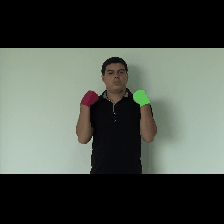

In [19]:
idx, row = next(subset_metadata_df.iterrows())

ucf_sample_video = frames_from_video_file(os.path.join(subset_path, row['sp'], row['gloss'], row['video_id']), 10)
to_gif(ucf_sample_video)

In [20]:
ucf_sample_video.shape

(10, 224, 224, 3)

In [21]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 16


In [22]:
n_frames = 10
batch_size = 8

# We specify the shape of the output, such as, the Generator will produce a tuple of both
# videos, class, where the videos will have 3 channels, and the rest of dimensions will remain the same.
#   VideoShape -> (F, H, W, C)
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)
# Also, we batchify the data, so the training process is not as memory consuming as if the whole dataset was 
# loaded into memory.
# VideoShape -> (B, F, H, W, C)
# train_ds = train_ds.batch(batch_size)
train_ds = train_ds.batch(batch_size)

# We reproduce this process for the validation and test splits too.
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)

val_ds = val_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

In [23]:
CACHE_FLAG = False
if CACHE_FLAG:    
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [24]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


In [25]:
(None, *train_frames.shape[2:])

(None, 224, 224, 3)

# 3. Model definition and Training

In [26]:
model = tf.keras.Sequential([
    # Construct the input layer with no definite frame size.
    tf.keras.layers.InputLayer(input_shape=(None, *train_frames.shape[2:])),
    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=False,
        activation="relu",
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='sigmoid')
])
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(),
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 224, 224, 6  154624    
                             4)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 224, 224, 6  256      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 224, 224, 64)      295168    
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                 

In [27]:
random_video = tf.random.uniform((8, 10, 224, 224, 3))
model(random_video)

<tf.Tensor: shape=(8, 10), dtype=float32, numpy=
array([[0.49258384, 0.49573258, 0.5047882 , 0.50981396, 0.49958122,
        0.50211674, 0.4964055 , 0.5019002 , 0.49763137, 0.49666852],
       [0.49259186, 0.49573725, 0.5047817 , 0.50980806, 0.49958348,
        0.5021126 , 0.49640527, 0.50189674, 0.49763563, 0.49667367],
       [0.49259505, 0.49573773, 0.50477993, 0.50980854, 0.49957967,
        0.5021141 , 0.49640435, 0.50189775, 0.49763575, 0.49667156],
       [0.4925857 , 0.4957361 , 0.5047849 , 0.50980586, 0.49958295,
        0.502112  , 0.49640882, 0.5018991 , 0.49763358, 0.49667168],
       [0.49259388, 0.49574137, 0.50478345, 0.50980693, 0.49958318,
        0.5021166 , 0.49640122, 0.5018977 , 0.4976322 , 0.49667317],
       [0.49258962, 0.4957369 , 0.50478625, 0.50981426, 0.49958408,
        0.5021146 , 0.49640423, 0.5018919 , 0.4976375 , 0.49667275],
       [0.49259388, 0.49573877, 0.5047832 , 0.509807  , 0.49958402,
        0.50211406, 0.49640945, 0.50189227, 0.4976381 , 0.496

In [28]:
conv2d = tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )

conv2d(train_frames)

<tf.Tensor: shape=(8, 10, 224, 224, 64), dtype=float32, numpy=
array([[[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          

In [29]:
# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20

# Fit the model to the training data using a generator.
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv_lstm2d/while/convolution_4' defined at (most recent call last):
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_487/2762786983.py", line 9, in <module>
      model.fit(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/layers/rnn/base_conv_lstm.py", line 506, in call
      return super().call(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/layers/rnn/base_conv_rnn.py", line 327, in call
      last_output, outputs, states = backend.rnn(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/backend.py", line 5139, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/backend.py", line 5118, in _step
      output, new_states = step_function(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/layers/rnn/base_conv_rnn.py", line 325, in step
      return self.cell.call(inputs, states, **kwargs)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/layers/rnn/base_conv_lstm.py", line 274, in call
      h_i = self.recurrent_conv(h_tm1_i, recurrent_kernel_i)
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/layers/rnn/base_conv_lstm.py", line 314, in recurrent_conv
      conv_out = self._conv_func(
    File "/home/javiermunoz/anaconda3/envs/dev-ml-environment/lib/python3.10/site-packages/keras/backend.py", line 6039, in conv2d
      x = tf.compat.v1.nn.convolution(
Node: 'sequential/conv_lstm2d/while/convolution_4'
OOM when allocating tensor with shape[8,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/conv_lstm2d/while/convolution_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_16085]